### 1.0 Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import datetime as dt
from math import radians, cos, sin, asin, sqrt #using this for calculating the distance between points

### 2.0 Load Data

Loading in the cleaned, exported data from my data wrangling step.

In [2]:
#load trees data we exported in the prior step
trees_data = pd.read_csv('../data/data_outputs/seattle_trees.csv')

#load climate data we exported in the prior step
climate_data = pd.read_csv('../data/data_outputs/washington_climate_normals.csv')

#### 2.1 Precipitation Data

After testing this out with climate normals data, I only ended up with 3 useful stations for data. So while I was excited to have the 'normals' which is averages over a 15-20 year period, I want to now test pulling in some other data I found.
\
\
The Community Collaborative Rain, Hail, & Snow Network has some great tools to access data. Unfortunately, it is only for the 2022 calendar year. I don't love that, but I think it will give me more useful datapoints to and make the analysis more valuable.
\
\
When pulling this data, I filtered down to all available weather stations in King County, Washington, which includes the Seattle proper. Upon further testing, I realized how 'collaborative' this data really is - relying on manual input. Because of this there is a lot of incomplete data we'll need to work through. I don't love this, and it comes back to me not being able to find a solid data source with long-term, complete data. I think it poses a fun and interesting challenge on how to impute information to make this data useable. My initial thoughts are to use a few of the more complete stations, calculate some "normals" on daily averages, and use them to beef up the others stations's data. This won't be perfect because I won't know which time of year has missing data (rainy or dry season?), but it wil have to do!
\
\
https://merbgai.cocorahs.org/Stations/ListStations.aspx

In [3]:
prcp_22 = pd.read_excel('../data/precip_2022.xlsx', sheet_name=0)
print(prcp_22.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Station Number              73 non-null     object 
 1   Station Name                73 non-null     object 
 2   Daily Precipitation Sum MM  73 non-null     float64
 3   Multi-Day Precipitation mm  46 non-null     float64
 4   Total Precipitation mm      73 non-null     float64
 5   Daily Snow Sum cm           73 non-null     float64
 6   # of Reports                73 non-null     int64  
 7   Latitude                    73 non-null     float64
 8   Longitude                   73 non-null     float64
 9   Multi-Day Overlap Warning   8 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.8+ KB
None


In [4]:
prcp_22.head(3)

,Station Number,Station Name,Daily Precipitation Sum MM,Multi-Day Precipitation mm,Total Precipitation mm,Daily Snow Sum cm,# of Reports,Latitude,Longitude,Multi-Day Overlap Warning
0,WA-KG-3,Lake Forest Park 0.4 W,1111.2,NaN,1111.2,0.0,365,47.763558,-122.293917,NaN
1,WA-KG-4,Renton 3.2 E,149.1,NaN,149.1,0.0,21,47.484508,-122.127169,NaN
2,WA-KG-5,Mercer Island 1.5 NW,1043.4,NaN,1043.4,8.4,365,47.585900,-122.250900,NaN


**Observations**
\
\
The 'Total Precipitation mm' column should be the combination of the dailiy and multi-day column and the field we use. There is no multi-day column for snow, so that will be the column we can use for snow data.
\
\
I will need to confirm latitude & longitude data is complete. I also want to do some renaming of columns to make them a little more straight forward. So far what I've seen from the data, I don't need to worry about the multi-day 'warning', as I believe it is cumulative and not duplicative. I also think I'll convert the cm of snow into mm to match the precipitation. Go metric system!

### 3.0 Explore and Cleanup PRCP data

In [5]:
prcp_22.shape

(73, 10)

In [6]:
prcp_22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Station Number              73 non-null     object 
 1   Station Name                73 non-null     object 
 2   Daily Precipitation Sum MM  73 non-null     float64
 3   Multi-Day Precipitation mm  46 non-null     float64
 4   Total Precipitation mm      73 non-null     float64
 5   Daily Snow Sum cm           73 non-null     float64
 6   # of Reports                73 non-null     int64  
 7   Latitude                    73 non-null     float64
 8   Longitude                   73 non-null     float64
 9   Multi-Day Overlap Warning   8 non-null      object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.8+ KB


#### 3.0.1 Rename Fields

In [7]:
#Now I want to go through the precipitation data and rename the fields to be more Python friendly
prcp_22.rename(columns ={'Station Number': 'station_id', 'Station Name': 'station_name', 'Daily Precipitation Sum MM': 'daily_prcp_mm',
                         'Multi-Day Precipitation mm': 'multi_day_prcp_mm', 'Total Precipitation mm': 'total_prcp_mm',
                         'Daily Snow Sum cm': 'daily_snow_cm', '# of Reports': 'reports_#', 'Latitude': 'lat_prcp',
                         'Longitude': 'long_prcp', 'Multi-Day Overlap Warning': 'md_overlap'}, inplace=True)

#verify the names stuck
prcp_22.columns

Index(['station_id', 'station_name', 'daily_prcp_mm', 'multi_day_prcp_mm',
       'total_prcp_mm', 'daily_snow_cm', 'reports_#', 'lat_prcp', 'long_prcp',
       'md_overlap'],
      dtype='object')

#### 3.0.2 Missing Values

In [8]:
#view the % of rows which are missing data in each field
prcp_22.isnull().sum() / prcp_22.shape[0] * 100

station_id            0.000000
station_name          0.000000
daily_prcp_mm         0.000000
multi_day_prcp_mm    36.986301
total_prcp_mm         0.000000
daily_snow_cm         0.000000
reports_#             0.000000
lat_prcp              0.000000
long_prcp             0.000000
md_overlap           89.041096
dtype: float64

The missing values are both related to the multi-day preciptation, which I would expect to not be 100% complete (it's only used if multi-day entries were made)
For now, I'm actually most curious if the daily+multiday = total, which it should. Before changing or dropping anything, let's make sure those match.

#### 3.0.2.0 Validate the Parts Equal the Whole

In [9]:
# Store fund columns to sum against
prcp_columns = ['daily_prcp_mm', 'multi_day_prcp_mm']

# Find rows where prcp_columns row sum == total
prcp_equ = prcp_22[prcp_columns].sum(axis=1) == prcp_22['total_prcp_mm']

# Store consistent and inconsistent data
consistent_prcp = prcp_22[prcp_equ]
inconsistent_prcp = prcp_22[~prcp_equ]

# Store consistent and inconsistent data
print("Number of inconsistent records: ", inconsistent_prcp.shape[0])

Number of inconsistent records:  18


In [10]:
#What do those records look like? I'm going to look by unique station
inconsistent_prcp[['station_name','daily_prcp_mm','multi_day_prcp_mm','total_prcp_mm']].value_counts()

station_name          daily_prcp_mm  multi_day_prcp_mm  total_prcp_mm
Auburn 8.2 SE         1217.2         67.1               1284.2           1
Bellevue 1.8 W        1073.2         83.6               1156.7           1
Vashon 4.9 SE         373.1          101.6              474.7            1
Sheridan Beach 3.7 S  957.8          37.3               995.2            1
Seattle 4.9 SE        913.1          29.2               942.3            1
Seattle 4.9 NNE       220.0          232.2              452.1            1
Seattle 4.8 NNW       308.4          96.8               405.1            1
Seattle 4.6 NNE       179.1          265.7              444.8            1
Seattle 4.2 SW        931.7          98.6               1030.2           1
Seattle 4.0 NNW       418.1          3.8                421.9            1
Sammamish 3.0 ESE     1167.6         83.6               1251.2           1
Redmond 6.2 ESE       423.2          90.2               513.3            1
Redmond 1.7 N         970.8   

These variances appear to just be rounding, but to be thorough, we will add a new calculated field using the two parts.

#### 3.0.2.1 Re-Calculate Total Column and Drop Old Fields

In [11]:
#Create a new field using daily + multi-day. I'm also filling NaNs with 0 on the multi day in order to add correctly.
prcp_22['prcp_mm_22'] = prcp_22['daily_prcp_mm'] + prcp_22['multi_day_prcp_mm'].fillna(0)

In [12]:
#Rechecking with our new column
prcp_columns = ['daily_prcp_mm', 'multi_day_prcp_mm']
prcp_equ = prcp_22[prcp_columns].sum(axis=1) == prcp_22['prcp_mm_22'] #this time checking against our new column

consistent_prcp = prcp_22[prcp_equ]
inconsistent_prcp = prcp_22[~prcp_equ]

print("Number of inconsistent records: ", inconsistent_prcp.shape[0])

Number of inconsistent records:  0


That's better. Now I'll drop the old total column and daily column, but I will keep the multi_day column, because I think it may come in handy when imputing missing values later.

In [13]:
#drop the two columns
prcp_22.drop(columns=['daily_prcp_mm','total_prcp_mm'], inplace=True)

#print columns
prcp_22.columns

Index(['station_id', 'station_name', 'multi_day_prcp_mm', 'daily_snow_cm',
       'reports_#', 'lat_prcp', 'long_prcp', 'md_overlap', 'prcp_mm_22'],
      dtype='object')

#### 3.0.3 Synchronize Precipitation and Snowfall Data

Our data has mm for precipitation, but centimeters for snowfall. We want to convert these to the same units of measurement for furture use.

In [14]:
#Because the metric system is the best, I can easily create a new mm field for snow by multiplying my cm by 10.
prcp_22['snow_mm_22'] = prcp_22['daily_snow_cm']*10

#validate this resulting new column
prcp_22[['daily_snow_cm', 'snow_mm_22']].value_counts()

daily_snow_cm  snow_mm_22
0.0            0.0           37
0.5            5.0            2
2.0            20.0           2
2.8            28.0           2
5.1            51.0           2
3.8            38.0           2
19.0           190.0          1
11.2           112.0          1
13.5           135.0          1
13.7           137.0          1
17.8           178.0          1
19.6           196.0          1
10.2           102.0          1
19.8           198.0          1
20.0           200.0          1
20.3           203.0          1
63.5           635.0          1
10.4           104.0          1
8.1            81.0           1
8.9            89.0           1
8.4            84.0           1
0.2            2.0            1
7.1            71.0           1
6.6            66.0           1
5.6            56.0           1
4.8            48.0           1
3.5            35.0           1
2.5            25.0           1
1.3            13.0           1
1.0            10.0           1
0.8           

In [15]:
#This looks good so I'll drop the original field
prcp_22.drop(columns=['daily_snow_cm'], inplace=True)

prcp_22.columns

Index(['station_id', 'station_name', 'multi_day_prcp_mm', 'reports_#',
       'lat_prcp', 'long_prcp', 'md_overlap', 'prcp_mm_22', 'snow_mm_22'],
      dtype='object')

#### 3.0.4 Review Distribution of Rainfall and Snow Data

I know from reviewing the data source that it relies on manual data entry, but let's check out how widespread the distrubtion of the data is.

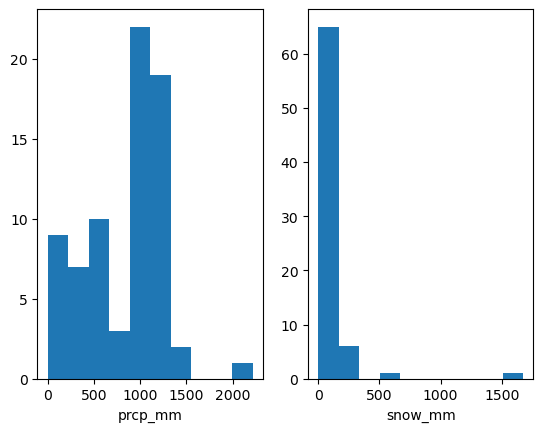

In [16]:
fig, ax = plt.subplots(1,2, squeeze=False)

ax[0,0].hist(prcp_22['prcp_mm_22'])
ax[0,1].hist(prcp_22['snow_mm_22'])
ax[0,0].set_xlabel('prcp_mm')
ax[0,1].set_xlabel('snow_mm')

plt.show()

#### 3.0.5 Fix Incomplete Data
I'd say those distributions are far from normal. We already know this relies on collaborative manual data entry so we have some missing days. This is further complicated by the fact that multi-day reports only are counted for 1 day of reporting in the reports_# field. As an example of this, WA-KG-225 has a full 365 days of data. But 9 of the days were entered in a multi-day batch, so it shows as having only 356 reports.
\
\
This gives us an interesting, but solvable challenge. Using the 'prcp' and 'snow' data we do have, we can use the reports_# field to see how many days worth of precipitation we need to impute. My best idea is to set aside the stations with complete data, get their daily averages, and then map those to the nearest stations missing data. I was able to manually check a few of the more complete stations and feel the ones with at least 320 obervastion are pretty complete and could be used to create averages. But because of that issue where multi-day reports only count as 1 report_#, we'll need to make some assumptions to not over-impute.

##### 3.0.5.1 Calculate an Adjusted # of Reports


In [17]:
#We need to estimate how many reports aren't counted due to having multi-day reporting. We can estimate this and create an adjusted reports_# field using this formula:
# ((multi_day_prcp_mm / prcp_mm_22) * reports_#) + reports_# => % of total prcp from multi-day * counted reports = non-counted reports + counted reports = adjusted count

prcp_22['adj_reports'] = round(((prcp_22['multi_day_prcp_mm'].fillna(0) / prcp_22['prcp_mm_22']).fillna(0) * prcp_22['reports_#']) + prcp_22['reports_#'],0).astype(int) #doing fillna twice, once in the division to account for possible denominator errors, and then once on the product in case there are 0 multi days AND 0 total prcp
prcp_22['max_reports'] = 365 #create a field with the max possible days to then choose the proper adjusted days
prcp_22['adj_reports'] = prcp_22[['adj_reports','max_reports']].min(axis=1) #update adj_reports to be the lessor of the calculated field or 365 max
prcp_22.drop(columns=['max_reports'],inplace=True) #drop the now unecessary max column

#let's check it out
prcp_22.sample(10)

,station_id,station_name,multi_day_prcp_mm,reports_#,lat_prcp,long_prcp,md_overlap,prcp_mm_22,snow_mm_22,adj_reports
64,WA-KG-287,Seattle 2.5 SE,535.7,236,47.596610,-122.311420,* Includes multi-day report ending on 1/3/2023.,1138.7,35.0,347
35,WA-KG-226,Redmond 1.7 N,55.1,348,47.697944,-122.108127,NaN,1025.9,135.0,365
50,WA-KG-263,Lake Forest Park 0.8 SSE,NaN,199,47.751720,-122.279500,NaN,1032.0,0.0,199
70,WA-KG-299,Seattle 4.9 NNE,NaN,61,47.685600,-122.306370,NaN,369.3,0.0,61
28,WA-KG-196,Des Moines 2.9 S,NaN,255,47.353863,-122.318054,NaN,646.7,0.0,255
41,WA-KG-238,Seattle 5.0 NE,65.5,330,47.674780,-122.277570,NaN,1029.7,25.0,351
13,WA-KG-65,Bellevue 1.8 W,83.6,350,47.604565,-122.193107,NaN,1156.8,56.0,365
59,WA-KG-280,Seattle 4.6 NNE,265.7,50,47.681610,-122.308558,NaN,444.8,0.0,80
58,WA-KG-277,Auburn 1.3 NE,28.7,11,47.313902,-122.196595,NaN,80.3,0.0,15
26,WA-KG-181,Lake Forest Park 0.7 WNW,221.7,307,47.765674,-122.300135,* Includes multi-day report starting on 12/26...,1069.3,0.0,365


##### 3.0.5.2 Calculate Daily Average from Most Complete Stations

These more complete stations will be the basis for imputing the rest of the incomeplete data from the others stations.

In [18]:
#subset my 2022 prcp dataframe to only those with reports_# of at least 200 and adj_reports of atleast 320 and drop duplicates.
prcp_subset = prcp_22[(prcp_22['adj_reports'] >= 320) & (prcp_22['reports_#'] >= 200)][['station_id','station_name','lat_prcp','long_prcp','reports_#','adj_reports','prcp_mm_22','snow_mm_22']].drop_duplicates('station_id', keep='first')

prcp_subset.shape

(34, 8)

In [19]:
#Now let's calculate daily averages
prcp_subset['norm_prcp_daily_avg'] = prcp_subset['prcp_mm_22'] / prcp_subset['adj_reports'] #using 'norm_' to signify these are more normalized numbers
prcp_subset['norm_snow_daily_avg'] = prcp_subset['snow_mm_22'] / prcp_subset['adj_reports'] #using 'norm_' to signify these are more normalized numbers

prcp_subset.sort_values('reports_#').head(10)

,station_id,station_name,lat_prcp,long_prcp,reports_#,adj_reports,prcp_mm_22,snow_mm_22,norm_prcp_daily_avg,norm_snow_daily_avg
64,WA-KG-287,Seattle 2.5 SE,47.596610,-122.311420,236,347,1138.7,35.0,3.281556,0.100865
17,WA-KG-78,Woodinville 0.9 ENE,47.753074,-122.094256,298,365,1189.7,190.0,3.259452,0.520548
10,WA-KG-51,Kenmore 0.9 WNW,47.771401,-122.258461,304,365,1155.9,0.0,3.166849,0.000000
26,WA-KG-181,Lake Forest Park 0.7 WNW,47.765674,-122.300135,307,365,1069.3,0.0,2.929589,0.000000
31,WA-KG-204,Seattle 0.9 SSE,47.609077,-122.343988,314,359,939.8,0.0,2.617827,0.000000
42,WA-KG-239,Seattle 3.9 N,47.676830,-122.363210,317,341,984.5,0.0,2.887097,0.000000
12,WA-KG-61,Redmond 3.7 N,47.727397,-122.102078,327,333,1207.5,198.0,3.626126,0.594595
39,WA-KG-234,Matthews Beach 0.4 NW,47.700155,-122.280497,328,354,1045.0,0.0,2.951977,0.000000
36,WA-KG-229,Seattle 5.5 NNE,47.696532,-122.312907,329,364,1087.1,0.0,2.986538,0.000000
38,WA-KG-232,Southworth 2.7 SSE,47.470924,-122.487314,329,329,1313.9,20.0,3.993617,0.060790


##### 3.0.5.3 Map Each Station to its nearest 'Complete' Station

To do this we'll use a formula that will come in handy later when combining our dataframes.

In [20]:
def dist_b_points(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees). 
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [21]:
def flag_nearest(lat, long, df2):
    """ 
    Label the closest weather station using the results of the dist_b_points function.
    I want to research and test this more. It seems weird to me that we specify the fields and df in the function, rather than use dynamic inputs.
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    distances = df2.apply(
        lambda row: dist_b_points(lat, long, row['lat_prcp'], row['long_prcp']), axis = 1)
    return df2.loc[distances.idxmin(), 'station_id']

In [22]:
#Use tje defined functions to add another field to pull in the ID from the nearest "complete" station
prcp_22['nearest_complete'] = prcp_22.apply(
    lambda row: flag_nearest(row['lat_prcp'], row['long_prcp'],prcp_subset), axis=1)

In [23]:
prcp_22.head(3)

,station_id,station_name,multi_day_prcp_mm,reports_#,lat_prcp,long_prcp,md_overlap,prcp_mm_22,snow_mm_22,adj_reports,nearest_complete
0,WA-KG-3,Lake Forest Park 0.4 W,NaN,365,47.763558,-122.293917,NaN,1111.2,0.0,365,WA-KG-3
1,WA-KG-4,Renton 3.2 E,NaN,21,47.484508,-122.127169,NaN,149.1,0.0,21,WA-KG-253
2,WA-KG-5,Mercer Island 1.5 NW,NaN,365,47.585900,-122.250900,NaN,1043.4,84.0,365,WA-KG-5


##### 3.0.5.4 Merge Subset into Main DF

This will get our orginal data and daily averages into the same dataframe to then do calculations on.

In [24]:
#merge in our new "complete" daily averages that we will then use to fill in the gaps an drop the duplicative id column
prcp_22 = pd.merge(prcp_22, prcp_subset[['station_id','station_name','norm_prcp_daily_avg','norm_snow_daily_avg']], left_on='nearest_complete', right_on='station_id', how='inner', suffixes=('','_nearest')).drop(columns=['station_id_nearest'])

prcp_22.head(3)


,station_id,station_name,multi_day_prcp_mm,reports_#,lat_prcp,long_prcp,md_overlap,prcp_mm_22,snow_mm_22,adj_reports,nearest_complete,station_name_nearest,norm_prcp_daily_avg,norm_snow_daily_avg
0,WA-KG-3,Lake Forest Park 0.4 W,NaN,365,47.763558,-122.293917,NaN,1111.2,0.0,365,WA-KG-3,Lake Forest Park 0.4 W,3.044384,0.000000
1,WA-KG-263,Lake Forest Park 0.8 SSE,NaN,199,47.751720,-122.279500,NaN,1032.0,0.0,199,WA-KG-3,Lake Forest Park 0.4 W,3.044384,0.000000
2,WA-KG-4,Renton 3.2 E,NaN,21,47.484508,-122.127169,NaN,149.1,0.0,21,WA-KG-253,Renton 2.7 NE,3.341758,0.549451


##### 3.0.5.5 Calculate New Totals

Now that we have averages from the nearest 'complete' station in the same record as each station, we can calculate new totals.

In [25]:
#fill in missing days with daily avg prcp from our nearest "complete" station if the reports are less than 300
prcp_22['norm_prcp_mm_total'] = np.where((prcp_22['adj_reports'] < 320), prcp_22['prcp_mm_22'] + ((365-prcp_22['adj_reports'])*prcp_22['norm_prcp_daily_avg']), prcp_22['prcp_mm_22'])

#fill in missing days with daily avg prcp from our nearest "complete" station if the reports are less than 300
#but since snow can be very elevation base, let's only imput values if the original records include snow as well. To do this I'll use np.where to make it coniditonal.
prcp_22['norm_snow_mm_total'] = np.where((prcp_22['snow_mm_22'] > 0) & (prcp_22['adj_reports'] < 320), prcp_22['snow_mm_22'] + ((365-prcp_22['adj_reports'])*prcp_22['norm_snow_daily_avg']), prcp_22['snow_mm_22'])

In [26]:
prcp_22.sample(10, replace=False)

,station_id,station_name,multi_day_prcp_mm,reports_#,lat_prcp,long_prcp,md_overlap,prcp_mm_22,snow_mm_22,adj_reports,nearest_complete,station_name_nearest,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
55,WA-KG-271,Redmond 7.6 ESE,187.2,112,47.643630,-121.958530,NaN,697.5,28.0,142,WA-KG-240,Sammamish 3.0 ESE,3.427945,0.243836,1461.931781,82.375342
58,WA-KG-210,Burien 2.1 NNW,487.2,213,47.491944,-122.365000,NaN,997.2,0.0,317,WA-KG-258,Seattle 6.4 S,3.118356,0.104110,1146.881096,0.000000
53,WA-KG-154,Redmond 6.2 ESE,90.2,92,47.640642,-121.991158,* Includes multi-day report starting on 12/27...,513.4,0.0,108,WA-KG-240,Sammamish 3.0 ESE,3.427945,0.243836,1394.381918,0.000000
12,WA-KG-298,Maple Valley 1.5 S,NaN,51,47.379516,-122.022890,NaN,181.6,28.0,51,WA-KG-9,Kent 2.9 ENE,3.033425,0.000000,1134.095342,28.000000
60,WA-KG-204,Seattle 0.9 SSE,134.9,314,47.609077,-122.343988,NaN,939.8,0.0,359,WA-KG-204,Seattle 0.9 SSE,2.617827,0.000000,939.800000,0.000000
40,WA-KG-273,Woodinville 2.7 NE,116.8,86,47.775481,-122.072100,NaN,489.9,2.0,107,WA-KG-78,Woodinville 0.9 ENE,3.259452,0.520548,1330.838630,136.301370
25,WA-KG-59,Issaquah 3.6 NW,NaN,319,47.567689,-122.089876,NaN,951.5,0.0,319,WA-KG-94,Bellevue 2.3 SSE,3.582073,0.568627,1116.275350,0.000000
27,WA-KG-231,Bellevue 1.1 SE,NaN,2,47.593970,-122.136311,NaN,0.0,0.0,2,WA-KG-94,Bellevue 2.3 SSE,3.582073,0.568627,1300.292437,0.000000
49,WA-KG-88,Federal Way 2.5 NNE,105.9,359,47.346000,-122.322000,NaN,1135.4,66.0,365,WA-KG-88,Federal Way 2.5 NNE,3.110685,0.180822,1135.400000,66.000000
29,WA-KG-61,Redmond 3.7 N,23.4,327,47.727397,-122.102078,NaN,1207.5,198.0,333,WA-KG-61,Redmond 3.7 N,3.626126,0.594595,1207.500000,198.000000


In [27]:
#recheck numerical values
prcp_22[['norm_prcp_mm_total','norm_snow_mm_total']].describe()

,norm_prcp_mm_total,norm_snow_mm_total
count,73.000000,73.000000
mean,1225.150577,76.403379
std,219.621114,222.568051
min,849.190323,0.000000
25%,1088.900000,0.000000
50%,1196.480274,0.000000
75%,1298.664835,82.375342
max,2216.200000,1676.000000


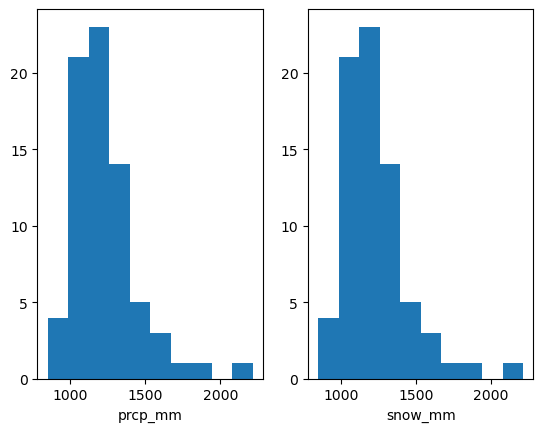

In [28]:
fig, ax = plt.subplots(1,2, squeeze=False)

ax[0,0].hist(prcp_22['norm_prcp_mm_total'])
ax[0,1].hist(prcp_22['norm_prcp_mm_total'])
ax[0,0].set_xlabel('prcp_mm')
ax[0,1].set_xlabel('snow_mm')

plt.show()

That looks a bit better but there are still some extreme values in each. I'll look specifically at the lowest and highest values.

In [29]:
#I've been getting a weird added text before my station_id, so this will clean that up for use later
prcp_22['station_id'] = prcp_22['station_id'].str.split().str.join(' ')

#Create another unique df with my fields in question
unique_updated = prcp_22[['station_id','station_name','reports_#','adj_reports','multi_day_prcp_mm','prcp_mm_22','snow_mm_22','nearest_complete','norm_prcp_daily_avg','norm_snow_daily_avg','norm_prcp_mm_total','norm_snow_mm_total']].drop_duplicates()

#Now let's recheck values, this time above 1,200 -> seeing this come up as a more likely 3rdQuartile for Seattle related locations
unique_updated[(unique_updated['norm_prcp_mm_total'] > 1200.0)].sort_values('station_id')

,station_id,station_name,reports_#,adj_reports,multi_day_prcp_mm,prcp_mm_22,snow_mm_22,nearest_complete,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
51,WA-KG-105,Vashon 4.9 SE,86,104,101.6,474.7,0.0,WA-KG-275,2.914783,0.000000,1235.458261,0.000000
10,WA-KG-143,North Bend 5.4 ESE,364,364,NaN,2216.2,1676.0,WA-KG-143,6.088462,4.604396,2216.200000,1676.000000
42,WA-KG-145,Seattle 4.2 N,89,89,0.5,415.3,5.0,WA-KG-239,2.887097,0.000000,1212.138710,5.000000
53,WA-KG-154,Redmond 6.2 ESE,92,108,90.2,513.4,0.0,WA-KG-240,3.427945,0.243836,1394.381918,0.000000
43,WA-KG-192,Seattle 5.6 N,122,172,366.5,898.9,71.0,WA-KG-239,2.887097,0.000000,1456.109677,71.000000
61,WA-KG-219,Carnation 3.6 N,359,359,NaN,1462.3,81.0,WA-KG-219,4.073259,0.225627,1462.300000,81.000000
27,WA-KG-231,Bellevue 1.1 SE,2,2,NaN,0.0,0.0,WA-KG-94,3.582073,0.568627,1300.292437,0.000000
65,WA-KG-232,Southworth 2.7 SSE,329,329,0.0,1313.9,20.0,WA-KG-232,3.993617,0.060790,1313.900000,20.000000
54,WA-KG-240,Sammamish 3.0 ESE,349,365,83.6,1251.2,89.0,WA-KG-240,3.427945,0.243836,1251.200000,89.000000
31,WA-KG-252,Medina 0.6 ENE,124,124,NaN,518.4,0.0,WA-KG-65,3.169315,0.153425,1282.204932,0.000000


In [30]:
#how about abnormally low values below the min of our more complete values?
unique_updated[(unique_updated['norm_prcp_mm_total'] < 1000)].sort_values('station_id')

,station_id,station_name,reports_#,adj_reports,multi_day_prcp_mm,prcp_mm_22,snow_mm_22,nearest_complete,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
50,WA-KG-196,Des Moines 2.9 S,255,255,NaN,646.7,0.0,WA-KG-88,3.110685,0.180822,988.875342,0.000000
57,WA-KG-200,Seattle 5.8 SSE,290,290,NaN,669.3,8.0,WA-KG-258,3.118356,0.104110,903.176712,15.808219
60,WA-KG-204,Seattle 0.9 SSE,314,359,134.9,939.8,0.0,WA-KG-204,2.617827,0.000000,939.800000,0.000000
45,WA-KG-239,Seattle 3.9 N,317,341,75.9,984.5,0.0,WA-KG-239,2.887097,0.000000,984.500000,0.000000
46,WA-KG-294,Seattle 4.0 NNW,215,217,3.8,421.9,0.0,WA-KG-239,2.887097,0.000000,849.190323,0.000000
15,WA-KG-33,Sheridan Beach 3.7 S,353,365,37.3,995.1,104.0,WA-KG-33,2.726301,0.284932,995.100000,104.000000


There are some low values, but my main concern is on that right tail. I'm thinking the locations to the left of the mean won't look as bad if it wasn't so tailed. I do have some capability to manually pull daily reports for a specific location so I looked at these 12 above. My using daily averages from the closest 'complete' station assumes the days which did and didn't have data are randomnly distributed. But this could lead to some overstating if we recognize it's possible (and likely?) that people are more likely to upload data if it rains than if it doesn't. Meaning the days that are missing data are more likely to have 0 rainfall than the daily average of another station. This could especially be true on the stations with fewer data entries, but a high reported prcp_mm. 
\
\
To account for this, I'll take the records > 1,200mm and < 300 adj reports and add a 15% reduction factor just to be safe. 

In [162]:
unique_updated[(unique_updated['norm_prcp_mm_total'] > 1200.0) & (unique_updated['adj_reports'] < 300)].sort_values('adj_reports')

,station_id,station_name,reports_#,adj_reports,multi_day_prcp_mm,prcp_mm_22,snow_mm_22,nearest_complete,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
27,WA-KG-231,Bellevue 1.1 SE,2,2,NaN,0.0,0.0,WA-KG-94,3.582073,0.568627,1300.292437,0.000000
66,WA-KG-260,Vashon 5.0 SW,3,3,NaN,6.9,0.0,WA-KG-232,3.993617,0.060790,1452.589362,0.000000
38,WA-KG-277,Auburn 1.3 NE,11,15,28.7,80.3,0.0,WA-KG-76,3.377686,0.027548,1262.490083,0.000000
2,WA-KG-4,Renton 3.2 E,21,21,NaN,149.1,0.0,WA-KG-253,3.341758,0.549451,1298.664835,0.000000
5,WA-KG-286,Renton 2.8 N,31,31,0.0,181.6,0.0,WA-KG-253,3.341758,0.549451,1297.747253,0.000000
32,WA-KG-296,Mercer Island 1.3 ENE,61,61,0.0,255.5,0.0,WA-KG-65,3.169315,0.153425,1218.971781,0.000000
47,WA-KG-301,Seattle 4.8 NNW,52,64,96.8,405.2,0.0,WA-KG-239,2.887097,0.000000,1274.216129,0.000000
23,WA-KG-270,Bothell 0.7 SSW,72,72,NaN,298.4,0.0,WA-KG-51,3.166849,0.000000,1226.286849,0.000000
16,WA-KG-280,Seattle 4.6 NNE,50,80,265.7,444.8,0.0,WA-KG-33,2.726301,0.284932,1221.795890,0.000000
42,WA-KG-145,Seattle 4.2 N,89,89,0.5,415.3,5.0,WA-KG-239,2.887097,0.000000,1212.138710,5.000000


In [31]:
#get list of station_ids
unique_updated[(unique_updated['norm_prcp_mm_total'] > 1200.0) & (unique_updated['adj_reports'] < 300)].sort_values('adj_reports')['station_id'].unique()

array(['WA-KG-231', 'WA-KG-260', 'WA-KG-277', 'WA-KG-4', 'WA-KG-286',
       'WA-KG-296', 'WA-KG-301', 'WA-KG-270', 'WA-KG-280', 'WA-KG-145',
       'WA-KG-285', 'WA-KG-290', 'WA-KG-105', 'WA-KG-273', 'WA-KG-154',
       'WA-KG-42', 'WA-KG-28', 'WA-KG-252', 'WA-KG-281', 'WA-KG-271',
       'WA-KG-192', 'WA-KG-263', 'WA-KG-268'], dtype=object)

In [32]:
#list stations we want to adjust
to_adj = ['WA-KG-231', 'WA-KG-260', 'WA-KG-277', 'WA-KG-4', 'WA-KG-286',
       'WA-KG-296', 'WA-KG-301', 'WA-KG-270', 'WA-KG-280', 'WA-KG-145',
       'WA-KG-285', 'WA-KG-290', 'WA-KG-105', 'WA-KG-273', 'WA-KG-154',
       'WA-KG-42', 'WA-KG-28', 'WA-KG-252', 'WA-KG-281', 'WA-KG-271',
       'WA-KG-192', 'WA-KG-263', 'WA-KG-268']

#use a loop and .loc to flag our stations in question and adjust the norm_prcp_mm_total and norm_snow_mm_total fields
for station in to_adj:
    prcp_22.loc[prcp_22.station_id==station, 'norm_prcp_mm_total'] = prcp_22.loc[prcp_22.station_id==station, 'norm_prcp_mm_total'] * .85
    prcp_22.loc[prcp_22.station_id==station, 'norm_snow_mm_total'] = prcp_22.loc[prcp_22.station_id==station, 'norm_snow_mm_total'] * .85

In [33]:
prcp_22[prcp_22['station_id'].isin(to_adj)]

,station_id,station_name,multi_day_prcp_mm,reports_#,lat_prcp,long_prcp,md_overlap,prcp_mm_22,snow_mm_22,adj_reports,nearest_complete,station_name_nearest,norm_prcp_daily_avg,norm_snow_daily_avg,norm_prcp_mm_total,norm_snow_mm_total
1,WA-KG-263,Lake Forest Park 0.8 SSE,NaN,199,47.751720,-122.279500,NaN,1032.0,0.0,199,WA-KG-3,Lake Forest Park 0.4 W,3.044384,0.000000,1306.762521,0.000000
2,WA-KG-4,Renton 3.2 E,NaN,21,47.484508,-122.127169,NaN,149.1,0.0,21,WA-KG-253,Renton 2.7 NE,3.341758,0.549451,1103.865110,0.000000
3,WA-KG-42,Newport Hills 1.9 SSE,65.8,98,47.521080,-122.161270,* Includes multi-day report starting on 12/25...,507.0,0.0,111,WA-KG-253,Renton 2.7 NE,3.341758,0.549451,1152.435604,0.000000
5,WA-KG-286,Renton 2.8 N,0.0,31,47.522628,-122.201217,NaN,181.6,0.0,31,WA-KG-253,Renton 2.7 NE,3.341758,0.549451,1103.085165,0.000000
8,WA-KG-281,Mercer Island 1.3 SSE,NaN,127,47.551930,-122.221080,NaN,911.9,102.0,127,WA-KG-5,Mercer Island 1.5 NW,2.858630,0.230137,1353.415877,133.256712
13,WA-KG-28,Redmond 1.0 N,41.9,107,47.688790,-122.115850,NaN,922.5,51.0,112,WA-KG-226,Redmond 1.7 N,2.810685,0.369863,1388.562795,122.889041
16,WA-KG-280,Seattle 4.6 NNE,265.7,50,47.681610,-122.308558,NaN,444.8,0.0,80,WA-KG-33,Sheridan Beach 3.7 S,2.726301,0.284932,1038.526507,0.000000
20,WA-KG-285,Woodinville 3.3 ESE,NaN,90,47.723262,-122.049775,NaN,456.4,0.0,90,WA-KG-35,Woodinville 1.7 SE,3.631454,0.112760,1236.792374,0.000000
23,WA-KG-270,Bothell 0.7 SSW,NaN,72,47.749712,-122.201353,NaN,298.4,0.0,72,WA-KG-51,Kenmore 0.9 WNW,3.166849,0.000000,1042.343822,0.000000
27,WA-KG-231,Bellevue 1.1 SE,NaN,2,47.593970,-122.136311,NaN,0.0,0.0,2,WA-KG-94,Bellevue 2.3 SSE,3.582073,0.568627,1105.248571,0.000000


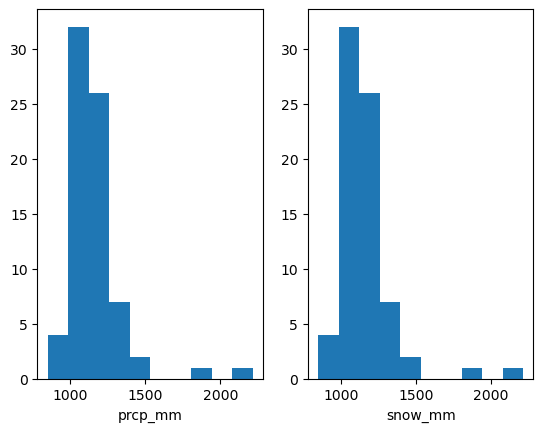

       norm_prcp_mm_total  norm_snow_mm_total
count           73.000000           73.000000
mean          1160.214877           75.178671
std            189.913491          222.333515
min            849.190323            0.000000
25%           1045.880645            0.000000
50%           1123.400000            0.000000
75%           1216.400000           81.000000
max           2216.200000         1676.000000


In [34]:
fig, ax = plt.subplots(1,2, squeeze=False)

ax[0,0].hist(prcp_22['norm_prcp_mm_total'])
ax[0,1].hist(prcp_22['norm_prcp_mm_total'])
ax[0,0].set_xlabel('prcp_mm')
ax[0,1].set_xlabel('snow_mm')

plt.show()

print(prcp_22[['norm_prcp_mm_total', 'norm_snow_mm_total']].describe())

We're down to just a coule of strange outliers, but they have complete data and I believe those are outside of our scope as our trees data is specific to Seattle Proper and these are in another part of the county. I will leave them for new and loop back if they do end up impacting my data.

##### 3.0.5.6 Drop Columns No Longer Needed

I no longer need the columns that helped me get to my final normalized amounts. So I'll drop those now.

In [36]:
prcp_22.columns

Index(['station_id', 'station_name', 'multi_day_prcp_mm', 'reports_#',
       'lat_prcp', 'long_prcp', 'md_overlap', 'prcp_mm_22', 'snow_mm_22',
       'adj_reports', 'nearest_complete', 'station_name_nearest',
       'norm_prcp_daily_avg', 'norm_snow_daily_avg', 'norm_prcp_mm_total',
       'norm_snow_mm_total'],
      dtype='object')

In [37]:
prcp_22_cleaned = prcp_22.drop(columns=['multi_day_prcp_mm', 'reports_#','md_overlap', 'prcp_mm_22', 'snow_mm_22','nearest_complete', 'station_name_nearest',
       'norm_prcp_daily_avg', 'norm_snow_daily_avg'])

prcp_22_cleaned.head(3)

,station_id,station_name,lat_prcp,long_prcp,adj_reports,norm_prcp_mm_total,norm_snow_mm_total
0,WA-KG-3,Lake Forest Park 0.4 W,47.763558,-122.293917,365,1111.200000,0.0
1,WA-KG-263,Lake Forest Park 0.8 SSE,47.751720,-122.279500,199,1306.762521,0.0
2,WA-KG-4,Renton 3.2 E,47.484508,-122.127169,21,1103.865110,0.0


#### 3.1 Tie Together The Two Dataframes Using Lat-Lon

##### 3.1.1 Rename Fields

In [38]:
#Need a reminder of my fields
trees_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162080 entries, 0 to 162079
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               159111 non-null  object 
 1   most_recent_observation    162075 non-null  object 
 2   common_name                161408 non-null  object 
 3   longitude_coordinate       162080 non-null  float64
 4   latitude_coordinate        162080 non-null  float64
 5   diameter_breast_height_CM  162080 non-null  float64
 6   condition                  162080 non-null  object 
 7   native                     162080 non-null  object 
 8   age_at_obs                 159106 non-null  float64
 9   condition_index            162080 non-null  float64
dtypes: float64(5), object(5)
memory usage: 12.4+ MB


In [39]:
prcp_22_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 0 to 72
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   station_id          73 non-null     object 
 1   station_name        73 non-null     object 
 2   lat_prcp            73 non-null     float64
 3   long_prcp           73 non-null     float64
 4   adj_reports         73 non-null     int64  
 5   norm_prcp_mm_total  73 non-null     float64
 6   norm_snow_mm_total  73 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 4.6+ KB


In [40]:
#Rename lat-long field in trees data to signify it is from this datasource. I could do this on a merge later, but I like to keep them seperate.
trees_data.rename(columns = {'longitude_coordinate': 'long_trees', 'latitude_coordinate': 'lat_trees'}, inplace=True)

##### 3.1.2 Map the Nearest Station to Each Tree Record

In [41]:
#Using my defined functions to add a field to my trees_data df which will list the ID for the nearest weather station.
trees_data['nearest_station'] = trees_data.apply(
    lambda row: flag_nearest(row['lat_trees'], row['long_trees'],prcp_22_cleaned), axis=1)

In [42]:
#explore results
trees_data['nearest_station'].value_counts()

WA-KG-239    16065
WA-KG-204    12400
WA-KG-280    11640
WA-KG-225    11626
WA-KG-258    11472
WA-KG-287    10225
WA-KG-200     9474
WA-KG-79      8940
WA-KG-266     8921
WA-KG-243     8778
WA-KG-272     8279
WA-KG-294     6749
WA-KG-301     6495
WA-KG-229     4918
WA-KG-238     4825
WA-KG-192     4377
WA-KG-199     4195
WA-KG-72      2565
WA-KG-234     2544
WA-KG-145     2369
WA-KG-33      1830
WA-KG-286     1138
WA-KG-299      796
WA-KG-297      676
WA-KG-263      492
WA-KG-5        236
WA-KG-81        34
WA-KG-210       21
Name: nearest_station, dtype: int64

This looks a lot better than the last data source, which only had 3 'nearest' stations. Let's now merge these in and explore a bit more.
##### 3.2.5 Merge Datasets Into a Single Table

In [43]:
#inner join on the station_id to create a master df to continue with my EDA.
trees_prcp_all = pd.merge(trees_data, prcp_22_cleaned, left_on='nearest_station', right_on='station_id', how='inner')

In [44]:
#check which stations came back, we'll use the station id later to split out for our map
trees_prcp_all[['station_id','station_name']].value_counts()

station_id  station_name            
WA-KG-239   Seattle 3.9 N               16065
WA-KG-204   Seattle 0.9 SSE             12400
WA-KG-280   Seattle 4.6 NNE             11640
WA-KG-225   Seattle 2.1 ESE             11626
WA-KG-258   Seattle 6.4 S               11472
WA-KG-287   Seattle 2.5 SE              10225
WA-KG-200   Seattle 5.8 SSE              9474
WA-KG-79    Seattle 3.0 WNW              8940
WA-KG-266   Seattle 2.9 ENE              8921
WA-KG-243   Seattle 3.9 SSW              8778
WA-KG-272   Seattle 4.9 SE               8279
WA-KG-294   Seattle 4.0 NNW              6749
WA-KG-301   Seattle 4.8 NNW              6495
WA-KG-229   Seattle 5.5 NNE              4918
WA-KG-238   Seattle 5.0 NE               4825
WA-KG-192   Seattle 5.6 N                4377
WA-KG-199   Seattle 4.5 N                4195
WA-KG-72    Seattle 4.2 SW               2565
WA-KG-234   Matthews Beach 0.4 NW        2544
WA-KG-145   Seattle 4.2 N                2369
WA-KG-33    Sheridan Beach 3.7 S         18

In [45]:
#Check how manyunique values of nearest station
len(trees_prcp_all['nearest_station'].unique())

28

##### 3.2.6 Validate Visually

I want to plot both the stations an the trees on the same plot/map to see if these make sense visually.

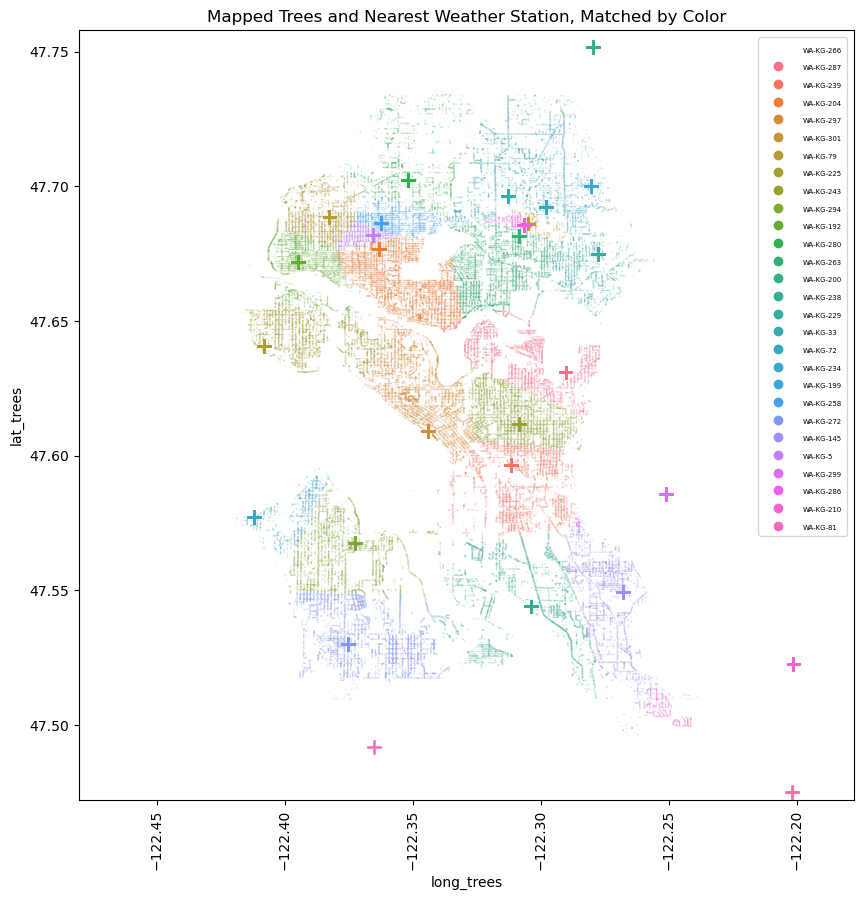

In [46]:
#Create a plot, splitting out the different points by color for their different closest stations and plot them on the same plane as the stations.
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(ax=ax, x='long_trees', y='lat_trees', data=trees_prcp_all, hue='nearest_station', marker='o', s=1, alpha=0.1)
sns.scatterplot(ax=ax, x='long_prcp', y='lat_prcp', data=trees_prcp_all, hue='nearest_station', marker='+', s=100)

#zoom into rough seattle area by adding some space around the min and max values
plt.axis([trees_prcp_all['long_trees'].min()*1.0005, trees_prcp_all['long_trees'].max()*.9995, trees_prcp_all['lat_trees'].min()*0.9995, trees_prcp_all['lat_trees'].max()*1.0005])

#create list for legend
leg_label = trees_prcp_all['nearest_station'].unique()

#set title, change legend font size, and rotate axis labels
ax.set_title('Mapped Trees and Nearest Weather Station, Matched by Color')
plt.legend(leg_label)
plt.setp(ax.get_legend().get_texts(), fontsize='5')
plt.xticks(rotation=90)
plt.show()

**Observations**
\
This isn't the prettiest graph, which such a long legend and no actual underlying map, but it does what I needed and shows the mapping function did work to flag the closest weather station to each tree. There are some some tree-station pair groupings, with the smallest being 26 tree records mapping closest to Burien 2.1 NNW station, I will let these play out as I do more EDA.
\
\
A next question I have is the location to the nearest station. I see some station '+' markers pretty isolated. They may still be the 'closest' but aren't close enough to be fully valuable. We can add another field with distance to the nearest station before moving on to the rest of our more 'traditional' EDA. This will give our data another variable that could prove useful.

##### 3.2.7 Distance Between Points

In [47]:
# Use our handy formula created above on our trees_prcp_all df using list comprehension on each row. This could be a lenghty run so let's see how it goes.

trees_prcp_all['distance_between'] = [dist_b_points(trees_prcp_all.long_trees[i], trees_prcp_all.lat_trees[i]
                                                    , trees_prcp_all.long_prcp[i], trees_prcp_all.lat_prcp[i]) 
                                                    for i in range(len(trees_prcp_all))]

In [48]:
#That actually ran really fast. Let's see how it went.
trees_prcp_all['distance_between'].describe()

count    162080.000000
mean          1.517032
std           0.977325
min           0.004214
25%           0.807316
50%           1.334919
75%           1.988311
max           7.514261
Name: distance_between, dtype: float64

It is a little hard to tell without mapping out a full map, but I know a quarter degree of longitude is around 8.5 miles. Looking at our plot above this appears plausible that the max disstance would be around 7.5km.

In [49]:
#Let's see how that looks in our df
trees_prcp_all.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,nearest_station,station_id,station_name,lat_prcp,long_prcp,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,0.947927
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,3.367105
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,1.145690


### 3.3 Temperature Normals Data

I pivoted to using a more wide ranging dataset for precipitation, but I still want a temperature component, so I'll add that now.

#### 3.3.0 Load Full Data

Using glob and list comprehension

In [50]:
#create path
path = "../data/climate_normals/"

all_climate_files = glob.glob(os.path.join(path, "*.csv"))


#load all .csv files in the fileapth into a df using concat and list comprehension
climate_all = pd.concat((pd.read_csv(f) for f in all_climate_files), ignore_index=True)

#### 3.3.1 Filter Down to Relevant Fields and Locations

In [51]:
#Explore results

climate_all.head()

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,month,day,hour,ANN-TAVG-NORMAL,meas_flag_ANN-TAVG-NORMAL,...,comp_flag_DJF-SNWD-AVGNDS-GE005WI,years_DJF-SNWD-AVGNDS-GE005WI,DJF-SNWD-AVGNDS-GE010WI,meas_flag_DJF-SNWD-AVGNDS-GE010WI,comp_flag_DJF-SNWD-AVGNDS-GE010WI,years_DJF-SNWD-AVGNDS-GE010WI,DJF-SNWD-AVGNDS-GE020WI,meas_flag_DJF-SNWD-AVGNDS-GE020WI,comp_flag_DJF-SNWD-AVGNDS-GE020WI,years_DJF-SNWD-AVGNDS-GE020WI
0,USW00003822,32.1300,-81.2100,14.0,"SAVANNAH INTL AP, GA US",99,99,99,67.4,,...,S,24.0,0.0,,S,24.0,0.0,,S,24.0
1,USW00023258,37.6242,-120.9506,22.3,"MODESTO CITY CO AP, CA US",99,99,99,63.1,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00063898,38.8883,-86.5708,231.6,"BEDFORD 5 WNW, IN US",99,99,99,54.3,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00004803,45.6308,-89.4653,487.4,"RHINELANDER ONEIDA AP, WI US",99,99,99,41.4,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00012907,27.5333,-99.4667,153.9,"LAREDO AFB, TX US",99,99,99,74.6,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
climate_all.shape

(1161, 2140)

In [53]:
#That is a lot columns wow. I did some digging through the source data and found the relevant fields I'll filter down to those now

climate_normals = climate_all[['STATION','LATITUDE','LONGITUDE','ELEVATION'
                                   ,'NAME','ANN-TAVG-NORMAL','comp_flag_ANN-TAVG-NORMAL'
                                   ,'years_ANN-TAVG-NORMAL','ANN-TMIN-NORMAL','comp_flag_ANN-TMIN-NORMAL'
                                   ,'years_ANN-TMIN-NORMAL','ANN-TMAX-NORMAL','comp_flag_ANN-TMAX-NORMAL'
                                   ,'years_ANN-TMAX-NORMAL','ANN-DUTR-NORMAL','comp_flag_ANN-DUTR-NORMAL'
                                   ,'years_ANN-DUTR-NORMAL','ANN-PRCP-NORMAL','comp_flag_ANN-PRCP-NORMAL'
                                   ,'years_ANN-PRCP-NORMAL']]

In [54]:
#Filter down rows to those that have 'WA' in them. This will pull in more than Washington, but not too many to slow down processes. So I won't go more specific and risk missing any.

wa_climate = climate_normals[climate_normals['NAME'].str.contains('WA')]

wa_climate.head(3)

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,ANN-TAVG-NORMAL,comp_flag_ANN-TAVG-NORMAL,years_ANN-TAVG-NORMAL,ANN-TMIN-NORMAL,comp_flag_ANN-TMIN-NORMAL,years_ANN-TMIN-NORMAL,ANN-TMAX-NORMAL,comp_flag_ANN-TMAX-NORMAL,years_ANN-TMAX-NORMAL,ANN-DUTR-NORMAL,comp_flag_ANN-DUTR-NORMAL,years_ANN-DUTR-NORMAL,ANN-PRCP-NORMAL,comp_flag_ANN-PRCP-NORMAL,years_ANN-PRCP-NORMAL
11,USW00094790,43.9922,-76.0217,96.9,"WATERTOWN INTL AP, NY US",45.3,S,29.0,35.2,S,29.0,55.4,S,29.0,20.2,S,29.0,37.07,S,29.0
15,USW00023066,39.1342,-108.5400,1480.7,"GRAND JUNCTION WALKER FLD, CO US",53.2,S,28.0,39.8,S,28.0,66.6,S,29.0,26.8,S,28.0,9.06,S,30.0
26,USW00014755,44.2667,-71.2994,1910.2,"MT WASHINGTON, NH US",28.0,S,27.0,21.0,S,27.0,35.0,S,27.0,14.0,S,27.0,91.23,S,29.0


In [55]:
wa_climate.shape

(75, 20)

#### 3.3.2 Explore Dtypes and Distribution

I think I have what I need here for the next step, but I'm curious to check completeness and see if any of the categorical flags vary between stations. I may find it best to drop a few more columns or gain some understanding from these checks.

##### 3.3.2.0 Check Missing Values

In [56]:
#create dataframe with each column, missing records count, and missing percent
missing_cl = pd.concat([wa_climate.isna().sum(), 100 * wa_climate.isna().mean()], axis=1)
missing_cl.columns=['missing_count', 'missing_perc']
missing_cl.sort_values(by='missing_count', ascending=False)

,missing_count,missing_perc
years_ANN-PRCP-NORMAL,2,2.666667
comp_flag_ANN-PRCP-NORMAL,2,2.666667
ANN-PRCP-NORMAL,2,2.666667
LATITUDE,0,0.000000
years_ANN-DUTR-NORMAL,0,0.000000
comp_flag_ANN-DUTR-NORMAL,0,0.000000
ANN-DUTR-NORMAL,0,0.000000
years_ANN-TMAX-NORMAL,0,0.000000
comp_flag_ANN-TMAX-NORMAL,0,0.000000
ANN-TMAX-NORMAL,0,0.000000


In [57]:
#is it the same 2 records that are missing values
wa_climate[wa_climate['ANN-PRCP-NORMAL'].isna()]

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,ANN-TAVG-NORMAL,comp_flag_ANN-TAVG-NORMAL,years_ANN-TAVG-NORMAL,ANN-TMIN-NORMAL,comp_flag_ANN-TMIN-NORMAL,years_ANN-TMIN-NORMAL,ANN-TMAX-NORMAL,comp_flag_ANN-TMAX-NORMAL,years_ANN-TMAX-NORMAL,ANN-DUTR-NORMAL,comp_flag_ANN-DUTR-NORMAL,years_ANN-DUTR-NORMAL,ANN-PRCP-NORMAL,comp_flag_ANN-PRCP-NORMAL,years_ANN-PRCP-NORMAL
287,USW00024241,46.4833,-122.8167,115.5,"TOLEDO FAA AP, WA US",52.3,R,10.0,42.3,R,10.0,62.3,R,10.0,19.9,R,10.0,NaN,NaN,NaN
456,USW00027503,70.6392,-159.9950,9.1,"WAINWRIGHT AP, AK US",14.8,R,18.0,8.8,R,18.0,20.9,R,18.0,12.1,R,18.0,NaN,NaN,NaN


They do come from the same two stations, and I don't think these are close enough geographically to play into our data.

##### 3.3.2.1 Check Distribution of Categorical Value

I know from the documentation the 'comp_flag' has 4 possible values (S = Standard 24+ years, R = Representative 10+ years and missing months filled by surrounding stations, P = Provisional 10+ years and missing months not filled, E = Estimate 2+ years). 

The 'years_ann' fields list the numbers of years from which data was pulled from to calculate the normals. 

I'm hoping to see 'S' or 'R' and at least 10 in these fields for each record.

In [58]:
#view comp flag counts
print(wa_climate['comp_flag_ANN-DUTR-NORMAL'].value_counts())
print(wa_climate['comp_flag_ANN-PRCP-NORMAL'].value_counts())
print(wa_climate['comp_flag_ANN-TAVG-NORMAL'].value_counts())
print(wa_climate['comp_flag_ANN-TMAX-NORMAL'].value_counts())
print(wa_climate['comp_flag_ANN-TMIN-NORMAL'].value_counts())


#view minimum years in data
print(wa_climate['years_ANN-DUTR-NORMAL'].min())
print(wa_climate['years_ANN-PRCP-NORMAL'].min())
print(wa_climate['years_ANN-TAVG-NORMAL'].min())
print(wa_climate['years_ANN-TMAX-NORMAL'].min())
print(wa_climate['years_ANN-TMAX-NORMAL'].min())
print(wa_climate['years_ANN-TMIN-NORMAL'].min())

R    46
S    28
E     1
Name: comp_flag_ANN-DUTR-NORMAL, dtype: int64
R    40
S    31
E     1
P     1
Name: comp_flag_ANN-PRCP-NORMAL, dtype: int64
R    46
S    28
E     1
Name: comp_flag_ANN-TAVG-NORMAL, dtype: int64
R    41
S    33
E     1
Name: comp_flag_ANN-TMAX-NORMAL, dtype: int64
R    43
S    31
E     1
Name: comp_flag_ANN-TMIN-NORMAL, dtype: int64
7.0
3.0
7.0
8.0
8.0
7.0


In [59]:
#which stations use the 'E' or 'Esimtate'?

wa_climate[wa_climate['comp_flag_ANN-DUTR-NORMAL'] == 'E']

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,ANN-TAVG-NORMAL,comp_flag_ANN-TAVG-NORMAL,years_ANN-TAVG-NORMAL,ANN-TMIN-NORMAL,comp_flag_ANN-TMIN-NORMAL,years_ANN-TMIN-NORMAL,ANN-TMAX-NORMAL,comp_flag_ANN-TMAX-NORMAL,years_ANN-TMAX-NORMAL,ANN-DUTR-NORMAL,comp_flag_ANN-DUTR-NORMAL,years_ANN-DUTR-NORMAL,ANN-PRCP-NORMAL,comp_flag_ANN-PRCP-NORMAL,years_ANN-PRCP-NORMAL
360,USW00004134,40.1606,-113.3508,1310.6,"GRANITE PEAK DUGWAY PG, UT US",54.5,E,7.0,41.8,E,7.0,67.2,E,8.0,25.4,E,7.0,6.36,E,3.0


It's in Utah so I'll be safe.

##### 3.3.2.2 Check for Duplicates

In [60]:
duplicates = wa_climate.duplicated()
duplicated_records = wa_climate[duplicates].sort_values('STATION')

duplicated_records

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,ANN-TAVG-NORMAL,comp_flag_ANN-TAVG-NORMAL,years_ANN-TAVG-NORMAL,ANN-TMIN-NORMAL,comp_flag_ANN-TMIN-NORMAL,years_ANN-TMIN-NORMAL,ANN-TMAX-NORMAL,comp_flag_ANN-TMAX-NORMAL,years_ANN-TMAX-NORMAL,ANN-DUTR-NORMAL,comp_flag_ANN-DUTR-NORMAL,years_ANN-DUTR-NORMAL,ANN-PRCP-NORMAL,comp_flag_ANN-PRCP-NORMAL,years_ANN-PRCP-NORMAL


No duplicates! But these are still more stations than I need. I could map these out or look up the codes manually to find the few that are directly in an around Seattle. 

Instead of doign these, my idea is to actually do some "clustering" to map each of my trees to their closest weather station in our climate normals dataset. First let's finish some cleanup.

#### 3.3.3 Drop Columns

Since my categorical values were all consistent, I don't feel the need to keep them so I'll go ahead and drop.

In [61]:
#Drop the categorical comp_flag and years_ann fields
wash_climate = wa_climate.drop(columns=[
    'comp_flag_ANN-DUTR-NORMAL','comp_flag_ANN-PRCP-NORMAL','comp_flag_ANN-TAVG-NORMAL','comp_flag_ANN-TMAX-NORMAL','comp_flag_ANN-TMIN-NORMAL'
    ,'years_ANN-DUTR-NORMAL','years_ANN-PRCP-NORMAL','years_ANN-TAVG-NORMAL','years_ANN-TMAX-NORMAL','years_ANN-TMAX-NORMAL','years_ANN-TMIN-NORMAL'])

wash_climate.head(3)


,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,ANN-TAVG-NORMAL,ANN-TMIN-NORMAL,ANN-TMAX-NORMAL,ANN-DUTR-NORMAL,ANN-PRCP-NORMAL
11,USW00094790,43.9922,-76.0217,96.9,"WATERTOWN INTL AP, NY US",45.3,35.2,55.4,20.2,37.07
15,USW00023066,39.1342,-108.5400,1480.7,"GRAND JUNCTION WALKER FLD, CO US",53.2,39.8,66.6,26.8,9.06
26,USW00014755,44.2667,-71.2994,1910.2,"MT WASHINGTON, NH US",28.0,21.0,35.0,14.0,91.23


#### 3.3.4 Convert PRCP to mm

In [62]:
#convert using a factor of 25.4
wash_climate['ANN-PRCP-NORMAL'] = wash_climate['ANN-PRCP-NORMAL']*25.4

#### 3.3.5 Rename Columns
As great as the data is, the fields don't make semantic sense so let's update those!

In [63]:
wash_climate.rename(columns ={'ANN-TAVG-NORMAL': 'temp_avg_normal', 'ANN-TMIN-NORMAL': 'temp_min_normal', 'ANN-TMAX-NORMAL': 'temp_max_normal', 'ANN-DUTR-NORMAL': 'temp_range_normal', 'ANN-PRCP-NORMAL': 'prcp_mm_normal'}, inplace=True)

In [64]:
wash_climate.columns

Index(['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
       'temp_avg_normal', 'temp_min_normal', 'temp_max_normal',
       'temp_range_normal', 'prcp_mm_normal'],
      dtype='object')

#### 3.3.6 Match Trees to Climate Normals Data Based on Nearest Station

We'll do the same process as we did with the prcp data.

##### 3.3.6.0 Map Each Tree to Nearest Station

In [65]:
trees_prcp_all.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,nearest_station,station_id,station_name,lat_prcp,long_prcp,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,0.947927
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,3.367105
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,1.145690


In [66]:
wash_climate.head(3)

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal
11,USW00094790,43.9922,-76.0217,96.9,"WATERTOWN INTL AP, NY US",45.3,35.2,55.4,20.2,941.578
15,USW00023066,39.1342,-108.5400,1480.7,"GRAND JUNCTION WALKER FLD, CO US",53.2,39.8,66.6,26.8,230.124
26,USW00014755,44.2667,-71.2994,1910.2,"MT WASHINGTON, NH US",28.0,21.0,35.0,14.0,2317.242


In [67]:
#ran into some issues automating this function more , so defining it again with fields I need
def flag_nearest_normal(lat, long, df2):
    """ 
    Label the closest weather station using the results of the dist_b_points function.
    I want to research and test this more. It seems weird to me that we specify the fields and df in the function, rather than use dynamic inputs.
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    distances = df2.apply(
        lambda row: dist_b_points(lat, long, row['LATITUDE'], row['LONGITUDE']), axis = 1)
    return df2.loc[distances.idxmin(), 'STATION']

In [68]:
trees_prcp_all['nearest_normal_station'] = trees_prcp_all.apply(
    lambda row: flag_nearest_normal(row['lat_trees'], row['long_trees'],wash_climate), axis=1)

In [69]:
trees_prcp_all.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,nearest_station,station_id,station_name,lat_prcp,long_prcp,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,nearest_normal_station
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,0.947927,USW00094290
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,3.367105,USW00094290
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,WA-KG-266,WA-KG-266,Seattle 2.9 ENE,47.630883,-122.290286,237,1071.925479,0.0,1.145690,USW00094290


In [70]:
#Let's see all of the normals stations that matched, I'd only expect a few
trees_prcp_all['nearest_normal_station'].value_counts()

USW00094290    100326
USW00024234     60464
USW00094248      1290
Name: nearest_normal_station, dtype: int64

##### 3.3.6.1 Merge Normals Data into Main DF

Pull in our quantitative fields. Dropping the station name.

In [71]:
trees_prcp_all = pd.merge(trees_prcp_all, wash_climate[['STATION', 'temp_avg_normal', 'temp_min_normal', 'temp_max_normal',
       'temp_range_normal', 'prcp_mm_normal']], left_on='nearest_normal_station', right_on='STATION', how='left').drop(columns=['nearest_normal_station','STATION'])

#prcp_22 = pd.merge(prcp_22, prcp_subset[['station_id','station_name','norm_prcp_daily_avg','norm_snow_daily_avg']], left_on='nearest_complete', right_on='station_id', how='inner', suffixes=('','_nearest')).drop(columns=['station_id_nearest'])


In [72]:
trees_prcp_all.head(3)

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,long_prcp,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,-122.290286,237,1071.925479,0.0,0.947927,53.2,45.7,60.8,15.0,960.628
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,-122.290286,237,1071.925479,0.0,3.367105,53.2,45.7,60.8,15.0,960.628
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,-122.290286,237,1071.925479,0.0,1.145690,53.2,45.7,60.8,15.0,960.628


### 3.4 "Traditional" EDA

Now that we have a combined dataframe, let's move on to exploring it further with some fun EDA.

#### 3.4.1 Shape

We've done a lot of work on this, so let's get a reminder of the shape.

In [73]:
trees_prcp_all.shape

(162080, 24)

We're up to 19 fields, and still have all our 160k tree records. Let's keep going.

#### 3.4.2 Data Types and Column Info

In [74]:
trees_prcp_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162080 entries, 0 to 162079
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               159111 non-null  object 
 1   most_recent_observation    162075 non-null  object 
 2   common_name                161408 non-null  object 
 3   long_trees                 162080 non-null  float64
 4   lat_trees                  162080 non-null  float64
 5   diameter_breast_height_CM  162080 non-null  float64
 6   condition                  162080 non-null  object 
 7   native                     162080 non-null  object 
 8   age_at_obs                 159106 non-null  float64
 9   condition_index            162080 non-null  float64
 10  nearest_station            162080 non-null  object 
 11  station_id                 162080 non-null  object 
 12  station_name               162080 non-null  object 
 13  lat_prcp                   16

We have some missing values in planted_date, most_recent_observation, age_at_obs (expected as this was calculated of the prior two).
\
\
I feel like we will want to impute values for missing ages later but I will update some data types!

In [75]:
#We need to update our data fields to be datetime dtypes
trees_prcp_all['planted_date'] = pd.to_datetime(trees_prcp_all['planted_date'])
trees_prcp_all['most_recent_observation'] = pd.to_datetime(trees_prcp_all['most_recent_observation'])

trees_prcp_all[['planted_date','most_recent_observation']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162080 entries, 0 to 162079
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   planted_date             159111 non-null  datetime64[ns]
 1   most_recent_observation  162075 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 3.7 MB


#### 3.4.2 Add Unique tree_id field

This may not be totally necessary, but I think it will help me as I continue my EDA to assign each tree a simple unique numerical value.

In [76]:
#add id using index+1 to skip 0 and set the starting point to 1
trees_prcp_all['tree_id'] = trees_data.index+1

#convert this to an object
trees_prcp_all['tree_id'] = trees_prcp_all['tree_id'].astype(object)

In [77]:
#validate these are unique by value counting as taking the first 5 records, since value_counts defaults to sorted greatest to least
trees_prcp_all['tree_id'].value_counts().head(5)

1         1
108057    1
108050    1
108051    1
108052    1
Name: tree_id, dtype: int64

#### 3.4.3 Check for Duplicates

Duplicates may be realistic if two trees are planted next to eachother on the same date, but let's see if we find any.

In [78]:
duplicates = trees_prcp_all.duplicated()
duplicated_records = trees_prcp_all[duplicates].sort_values('tree_id')

duplicated_records

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,adj_reports,norm_prcp_mm_total,norm_snow_mm_total,distance_between,temp_avg_normal,temp_min_normal,temp_max_normal,temp_range_normal,prcp_mm_normal,tree_id


Nice! No exact duplicates

#### 3.4.4 Visualize Distributions

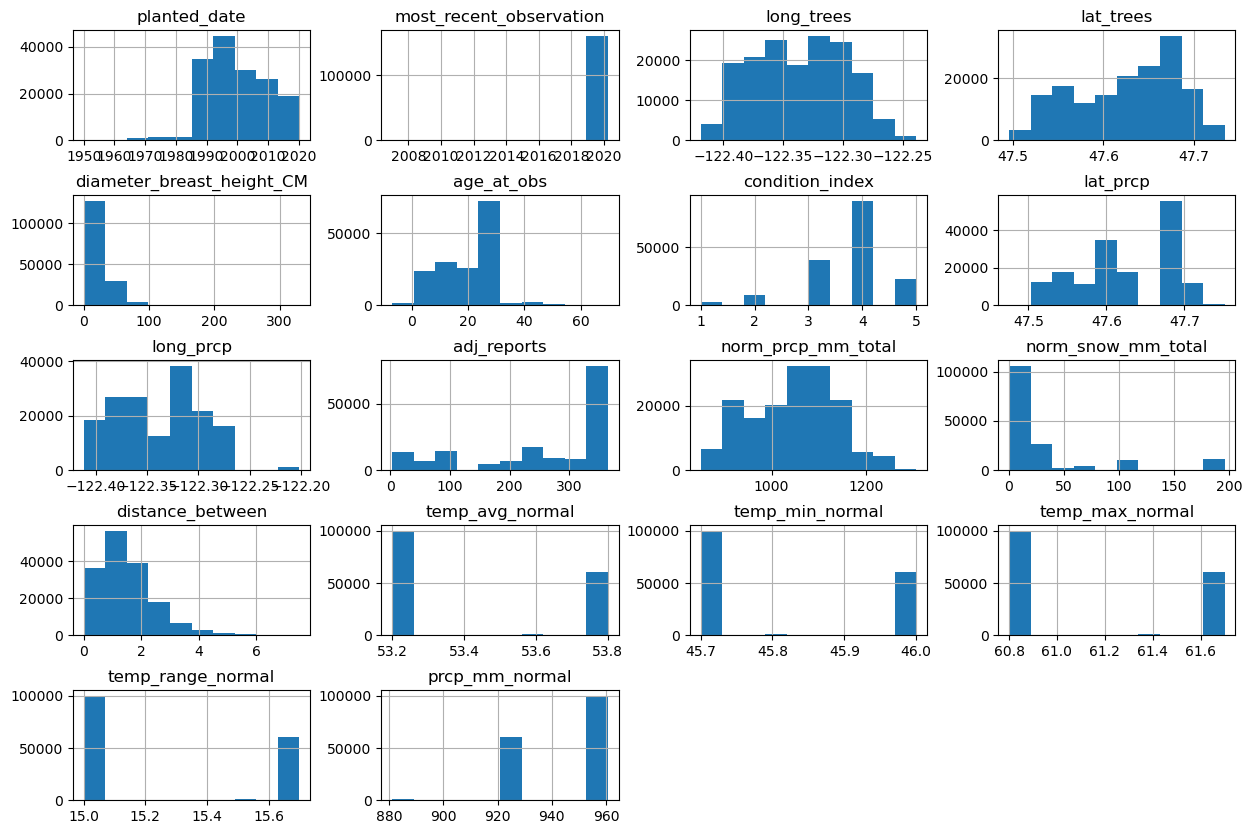

In [79]:
#Histograms
trees_prcp_all.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

**Observations:**
- Planted_date: There is a big jump in the 90s. It's possible there is an older section of the city that wasn't mapped with tree records, but the plot of trees looked pretty widely spread and the lat, lon above fits with the general area of the city. So for now I won't do anything.
- Diameter_breast_height_cm: There is likely a large record out to the right, so we'll need to check that out.
- Condition_index: Not many 1s and 2s. So we'll have to apply some steps in preprocessing to deal with this imbalance.
- Reports_# & Adj_reports: More shifted into that complete 365 window, making me think a lot of our trees are in the area that was just a few short.
- Distance_between: Most of are trees were fairly close to our nearest station data point.
- Precipitation & Snow Fields: Our largest outlier is gone, but there is still a bit of spread. We can look again at these amounts.
- 'Normals' Data - This only had 3 'nearest' stations so I didn't expect much of a distribution here. This will just add a bit of extra historical context to the model.

#### 3.4.5 Explore Diameter Field

It looks like there may be some outliers here.

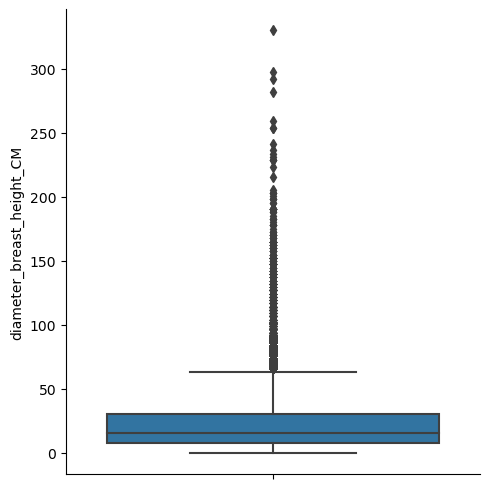

count    162080.000000
mean         21.514417
std          18.640934
min           0.000000
25%           7.620000
50%          15.240000
75%          30.480000
max         330.200000
Name: diameter_breast_height_CM, dtype: float64


In [80]:
#Visualize the data with a boxplot
sns.catplot(y="diameter_breast_height_CM", data=trees_prcp_all, kind="box")

plt.show()

print(trees_prcp_all['diameter_breast_height_CM'].describe())

In [81]:
#filter down to values > 1.5x the IQR
outliers = trees_prcp_all[trees_prcp_all['diameter_breast_height_CM'] > 30.48*1.5]

#display largest value of each tree
outliers.groupby('common_name').max('diameter_breast_height_CM').sort_values('diameter_breast_height_CM', ascending=False)['diameter_breast_height_CM']

common_name
Quaking aspen                       330.20
Giant sequoia                       297.18
Portugal laurel                     292.10
Bigleaf maple                       259.08
Port orford cedar lawson cypress    254.00
                                     ...  
Tatarian maple                       48.26
Swamp white oak                      48.26
Smooth sumac                         48.26
Sterling linden                      48.26
Autumn gold ginkgo                   48.26
Name: diameter_breast_height_CM, Length: 326, dtype: float64

We have 326 species with atleast one record over 1.5x the IQR. Breast height diameter is simply the diameter of the tree (width) at breast height. Not specifically the trunk, but reach of the tree. This could vary greatly for specifc trees, so I think it will be best to expand our view to see records which are beyond the typical range for a grouping of that species.
\
\
For consistency, I will consider a record an outlier if it is 1.5x the IQR.

In [82]:
#define function to establish what is an outlier
def get_outliers(col):
    q1 = np.percentile(col, 25)
    q3 = np.percentile(col, 75)
    iqr = q3-q1
    lower_threshold = q1 - (1.5*iqr)
    upper_threshold = q3 + (1.5*iqr)
    return sum((col<lower_threshold) | (col>upper_threshold))

In [83]:
outliers_by_group = trees_prcp_all.groupby('common_name')['diameter_breast_height_CM'].agg([get_outliers]).sort_values('get_outliers', ascending=False)

print(outliers_by_group)
print(outliers_by_group['get_outliers'].sum())

                                get_outliers
common_name                                 
Eddie's white wonder dogwood             153
American hornbeam                        150
(smooth) japanese maple                  117
Norway maple                             116
Autumn brilliance serviceberry            95
...                                      ...
New horizon elm                            0
Net leaf oak                               0
Myrtle california wax                      0
Chancelor littleleaf linden                0
Judas tree                                 0

[705 rows x 1 columns]
4537


According to that formula, Eddie's white wonder dogwood produced 153 outliers within it's own grouping. Let's explore the distribution for this one specifically.

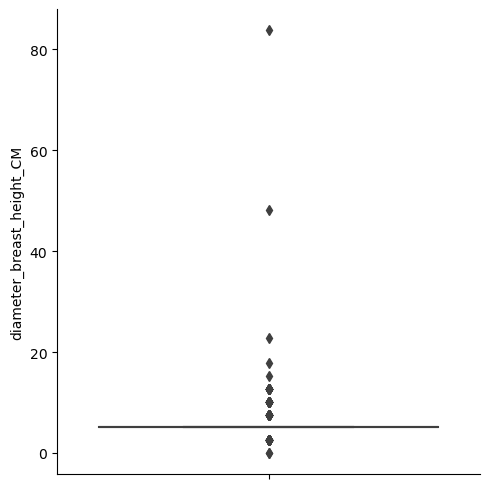

count    408.000000
mean       6.188137
std        5.197746
min        0.000000
25%        5.080000
50%        5.080000
75%        5.080000
max       83.820000
Name: diameter_breast_height_CM, dtype: float64


In [84]:
#Visualize the data with a boxplot
sns.catplot(y="diameter_breast_height_CM", data=trees_prcp_all[trees_prcp_all['common_name'] == "Eddie's white wonder dogwood"], kind="box")

plt.show()

print(trees_prcp_all[trees_prcp_all['common_name'] == "Eddie's white wonder dogwood"]['diameter_breast_height_CM'].describe())

In [85]:
#it looks like there is a really big cluster at the same diameter, let's see the value counts.
trees_prcp_all[trees_prcp_all['common_name'] == "Eddie's white wonder dogwood"]['diameter_breast_height_CM'].value_counts()

5.08     255
2.54      54
7.62      36
10.16     32
12.70     24
0.00       2
17.78      1
22.86      1
48.26      1
83.82      1
15.24      1
Name: diameter_breast_height_CM, dtype: int64

This is likely some generalization in the measurement, vs. 255 measured example at 5.08 centimeters. In total our calculation found 4,537 in-group outliers. That is less than 3% of our total dataset. Because it's such a small subset, I'm comfortable dropping our "outliers". I do wonder if there is a why I can make the dropping dynamic and only use the 1.5x IQR if the IQR is > 0 to avoid dropping records like we have for Eddie's Dogwood that are valid, but ouside of the 0 IQR.

#### 3.4.6 Drop Diameter Outliers

I think I'll actually go a bit manual and add the statistics to the data frame and then drop using a filter clause of some sort.

##### 3.4.6.1 Calculate Limits

In [86]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [87]:
#create summary statistics in a dataframe for each common_name gourping
df2 = (trees_prcp_all.groupby('common_name')
             .agg(Count=('diameter_breast_height_CM', 'count'),    
                  Mean=('diameter_breast_height_CM','mean'),
                  StDv=('diameter_breast_height_CM', 'std'),        
                  P25= ('diameter_breast_height_CM',percentile(25)), #This is for first quartile
                  P50= ('diameter_breast_height_CM',percentile(50)), #2nd Quartile
                  P75= ('diameter_breast_height_CM',percentile(75)),
                  )) #This is for Quartile 3

In [88]:
#calculate upper and lower outlier limits based on 1. 1.5X the IQR and 2. 3 STDEVs from the mean
df2['IQR'] = (df2['P75']-df2['P25'])
df2['lower_a'] = df2['P25'] - (df2['IQR']*1.5)
df2['upper_a'] = df2['P75'] + (df2['IQR']*1.5)
df2['lower_b'] = df2['Mean'] - (df2['StDv']*3)
df2['upper_b'] = df2['Mean'] + (df2['StDv']*3)

df2.head()

,Count,Mean,StDv,P25,P50,P75,IQR,lower_a,upper_a,lower_b,upper_b
common_name,,,,,,,,,,,
(american) arborvitae,603,17.573599,15.765731,7.620,12.70,20.32,12.700,-11.4300,39.3700,-29.723594,64.870791
(arnold) tulip tree,65,10.550769,7.257230,5.080,7.62,12.70,7.620,-6.3500,24.1300,-11.220921,32.322459
(california) incense cedar,220,29.267727,19.684401,14.605,27.94,40.64,26.035,-24.4475,79.6925,-29.785474,88.320929
(common) goldenchain,216,16.251296,8.997380,10.160,15.24,20.32,10.160,-5.0800,35.5600,-10.740845,43.243438
(european) bird cherry,21,22.013333,13.662587,12.700,17.78,30.48,17.780,-13.9700,57.1500,-18.974429,63.001095


##### 3.4.6.2 Merge Limits into Main DataFrame

In [89]:
trees_stats = pd.merge(trees_prcp_all, df2, on='common_name', how='left', suffixes=("", '_stats'))

trees_stats.head()

,planted_date,most_recent_observation,common_name,long_trees,lat_trees,diameter_breast_height_CM,condition,native,age_at_obs,condition_index,...,Mean,StDv,P25,P50,P75,IQR,lower_a,upper_a,lower_b,upper_b
0,1991-07-22,2019-04-27,(european) white birch,-122.282080,47.635207,40.64,excellent,introduced,27.765115,5.0,...,30.539531,14.880132,20.32,30.48,38.10,17.78,-6.35,64.77,-14.100865,75.179928
1,1991-07-30,2019-04-27,Kwanzan flowering cherry,-122.318952,47.649141,5.08,fair,no_info,27.743212,3.0,...,24.325238,14.743777,12.70,22.86,33.02,20.32,-17.78,63.50,-19.906092,68.556569
2,1991-07-25,2019-04-27,Japanese snowbell tree,-122.299891,47.637863,2.54,excellent,introduced,27.756901,5.0,...,9.593424,5.650118,5.08,7.62,12.70,7.62,-6.35,24.13,-7.356929,26.543777
3,1991-07-17,2019-04-27,Carriere (lavallei) hawthorn,-122.281439,47.630559,38.10,good,no_info,27.778804,4.0,...,16.948507,9.378874,10.16,15.24,22.86,12.70,-8.89,41.91,-11.188114,45.085128
4,1991-07-16,2019-04-27,Evergreen (southern) magnolia,-122.282837,47.627876,15.24,fair,introduced,27.781542,3.0,...,14.438071,9.985277,7.62,12.70,20.32,12.70,-11.43,39.37,-15.517758,44.393901


##### 3.4.6.3 Flag As Outlier or Not

In [90]:
#add outlier column using where clause that checks 1.5X the IQR if the IQR > 0. If it's not > 0 then it uses > 3 standard devaiations from the mean.
trees_stats['outlier'] = np.where((trees_stats['IQR'] > 0), ~trees_stats['diameter_breast_height_CM'].between(trees_stats['lower_a'], trees_stats['upper_a']), ~trees_stats['diameter_breast_height_CM'].between(trees_stats['lower_b'], trees_stats['upper_b']))
#now overwrite NaN values to not count as outliers
trees_stats['outlier'] = np.where((trees_stats['IQR'].isna()),'NoData', trees_stats['outlier'])

trees_stats['outlier'].value_counts()

False     157332
True        4076
NoData       672
Name: outlier, dtype: int64

##### 3.4.6.4 Drop 4,076 Outliers and Unecessary Fields

This is slightly less than our original estimate because we applied the logic that changed how we identified outliers if there was a 0 IQR.

In [91]:
#create new dataframe by filtering out outlier columns equal to 'True'
outliers = trees_stats['outlier'] == 'True'
trees_climate = trees_stats[~outliers]

In [92]:
print(trees_climate.shape)
print(trees_climate.columns)

(158004, 37)
Index(['planted_date', 'most_recent_observation', 'common_name', 'long_trees',
       'lat_trees', 'diameter_breast_height_CM', 'condition', 'native',
       'age_at_obs', 'condition_index', 'nearest_station', 'station_id',
       'station_name', 'lat_prcp', 'long_prcp', 'adj_reports',
       'norm_prcp_mm_total', 'norm_snow_mm_total', 'distance_between',
       'temp_avg_normal', 'temp_min_normal', 'temp_max_normal',
       'temp_range_normal', 'prcp_mm_normal', 'tree_id', 'Count', 'Mean',
       'StDv', 'P25', 'P50', 'P75', 'IQR', 'lower_a', 'upper_a', 'lower_b',
       'upper_b', 'outlier'],
      dtype='object')


In [93]:
trees_climate.drop(columns=['Count', 'Mean', 'StDv', 'P25', 'P50', 'P75', 'IQR',
       'lower_a', 'upper_a', 'lower_b', 'upper_b', 'outlier'], inplace=True)

/var/folders/_z/9zltq2bj1dz1k05g4mtz4gq00000gn/T/ipykernel_4435/1321155297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees_climate.drop(columns=['Count', 'Mean', 'StDv', 'P25', 'P50', 'P75', 'IQR',


In [94]:
trees_climate.columns

Index(['planted_date', 'most_recent_observation', 'common_name', 'long_trees',
       'lat_trees', 'diameter_breast_height_CM', 'condition', 'native',
       'age_at_obs', 'condition_index', 'nearest_station', 'station_id',
       'station_name', 'lat_prcp', 'long_prcp', 'adj_reports',
       'norm_prcp_mm_total', 'norm_snow_mm_total', 'distance_between',
       'temp_avg_normal', 'temp_min_normal', 'temp_max_normal',
       'temp_range_normal', 'prcp_mm_normal', 'tree_id'],
      dtype='object')

#### 3.4.7 Check PRCP Values One Last Time

In [95]:
#Create another unique df with my fields in question
unique_2 = trees_climate[['station_id','station_name','adj_reports','norm_prcp_mm_total','norm_snow_mm_total']].drop_duplicates()

#print summary stats
print(trees_climate[['norm_prcp_mm_total','norm_snow_mm_total']].describe())

#Now let's recheck values, this time above 1,500
unique_2[(unique_2['norm_prcp_mm_total'] > 1200.0)].sort_values('station_id')

       norm_prcp_mm_total  norm_snow_mm_total
count       158004.000000       158004.000000
mean          1047.810999           30.587999
std             88.707164           53.132131
min            849.190323            0.000000
25%            984.500000            0.000000
50%           1045.880645            0.000000
75%           1117.600000           38.000000
max           1306.762521          196.000000


,station_id,station_name,adj_reports,norm_prcp_mm_total,norm_snow_mm_total
90875,WA-KG-192,Seattle 5.6 N,172,1237.693226,60.35
106893,WA-KG-263,Lake Forest Park 0.8 SSE,199,1306.762521,0.00


We don't have a normal distribution, but I don't want to completely over-enginer this so I will leave it for now.

#### 3.4.8 Check Correlation/Covariance

/var/folders/_z/9zltq2bj1dz1k05g4mtz4gq00000gn/T/ipykernel_4435/1238981154.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = trees_climate.drop(columns=['lat_trees','long_trees','lat_prcp','long_prcp']).corr() #do not include lat & lon


[]

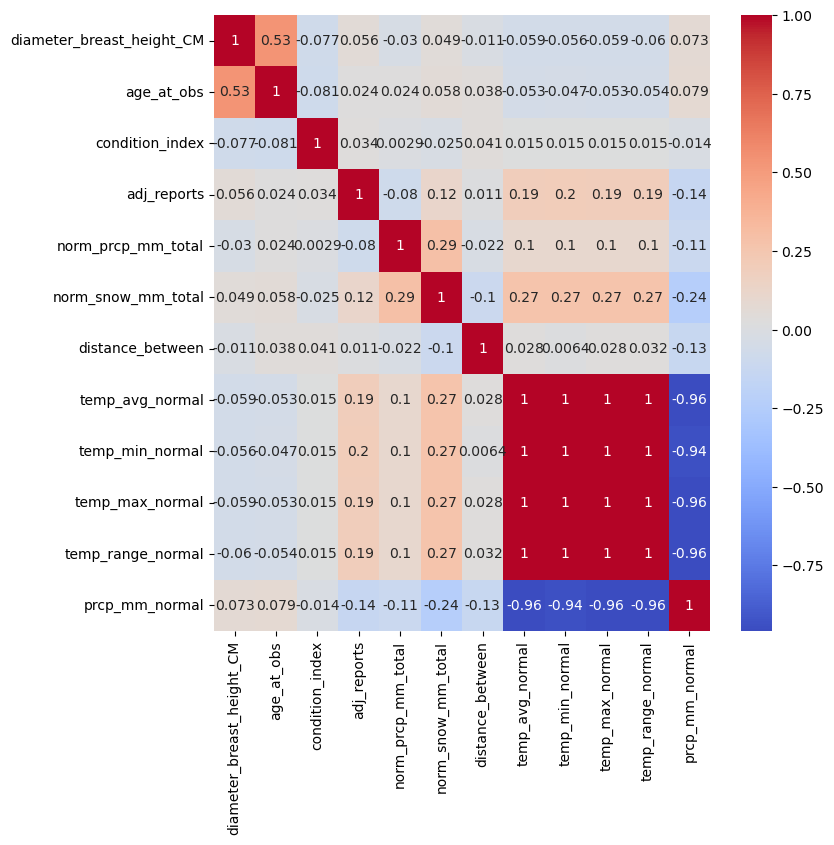

In [96]:
#create variable with values
corrMatrix = trees_climate.drop(columns=['lat_trees','long_trees','lat_prcp','long_prcp']).corr() #do not include lat & lon

fig, ax = plt.subplots(figsize=(8,8))

#plot with seaborn
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm')

plt.plot()

**Observations:**
\
Well, not a lot of correlation there. Ouch. I'll continue to move forward and plan on using some categorical fields and some non-linear regressions. So we'll see what we can come up with, but this was not totally unexpected when we pivoted from aiming for using this data to predict surface temperature or air quality to having my target feature come out of the trees data itself.
\
\
It does flow with what I would expect that there is some correlation between age and diameter, that makes me feel better about the quality of data itself. Same with some slight correlation between precipitation and snow fall. Since all of my climate normals are tied by only a few stations I don't think I need to include all thouse fields, and can likely just use the average temp and prcp.
\
\
On to the next!

### 3.5 Save Data

In [100]:
trees_climate.shape

(158004, 25)

In [228]:
# save trees data to a new csv
filepath = '../data/data_outputs/seattle_trees_explored.csv'
trees_climate.to_csv(filepath, index=False)

### Save Processed Data - Including Outliers

I wan to save off this full data and move it to the modeling phase, so I will do the same column drops on the dataframe and save it off.

In [97]:
trees_processed = trees_stats.drop(columns=['Count', 'Mean', 'StDv', 'P25', 'P50', 'P75', 'IQR',
       'lower_a', 'upper_a', 'lower_b', 'upper_b', 'outlier'])

In [101]:
trees_processed.shape

(162080, 25)

In [103]:
#save to a new csv
filepath = '../data/data_outputs/seattle_trees_explored_full.csv'
trees_processed.to_csv(filepath, index=False)